# Binary classification on Heart Attack dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

my_seed = 1
rng = np.random.default_rng(seed=my_seed) 

# Dataset
I used the dataset "_heart.cvs_". __[(Link)](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/data)__

This dataset contains health metrics from various individuals, including age, fasting blood sugar, and cholesterol levels, as well as whether they have experienced a heart attack. 

In particular the field "`output`" is equal to $1$ if the person had a heart attack, and $0$ otherwise. This is the quantity we want to predict.

In [2]:
df = pd.read_csv('heart.csv')
print(df.head())
print("\n", df.dtypes)
df.loc[df['cp'] == 4, 'cp'] = 0

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  

 age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object


## Structure of the data set
For each individual, the features include:
- `age` : Age of the individual
- `sex` : Sex (0 = female, 1 = male)
- `cp` : Chest Pain type
    - 0 = asymptomatic
    - 1 = typical angina
    - 2 = atypical angina
    - 3 = non-anginal pain
- `trtbps` : Resting blood pressure in mm Hg
- `chol` : Cholesterol in mg/dl
- `fbs` : Fasting blood sugar > 120mg/dl (0 = false, 1 = true)
- `restecg` : Resting electrocardiographic results
    - 0 = normal
    - 1 = having ST-T wave abnormality
    - 2 = showing probable or definite left ventricular hypertrophy 
- `thalachh` : Maximum heart rate achieved
- `exng` : Exercise induced angina (0 = no, 1 = yes)
- `output` : Experienced heart attack (0 = no, 1 = yes)

note: _Angina_ is a chest pain caused by reduced blood flow.

Since we have features that are real numbers (`age`, `fbs`), binary (`sex`, `exng`) and categorical (`cp`, `restecg`) we can consider them as real numbers.

The reasons why I decided not to use _One-hot encoding_ are two: first of all, I do not want to introduce too many variables in a dataset that already contains a small number of entries, secondly the values of the categorical variables have an interpretation: in the variable `restecg`, for example, the higher the number the more irregular is the electrocardiographic result.

### Train-Test split
We now split the dataset into a dataset that we will use to train the models, and a dataset that we will use to test them.

We can also make sure that there are no duplicated or null values in the data.

In [3]:
# Remove duplicates
print("There are {} duplicates in the dataset".format(df.duplicated().sum()))
print("There are {} null values in the dataset".format(df.isnull().sum().sum()))
df = df.drop_duplicates()

fraction_train = 0.8 
fraction_test = 1.0 - fraction_train
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train.info()
print("\nSize of the test set:", df_test.shape[0])

There are 1 duplicates in the dataset
There are 0 null values in the dataset
<class 'pandas.core.frame.DataFrame'>
Index: 241 entries, 215 to 216
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       241 non-null    int64  
 1   sex       241 non-null    int64  
 2   cp        241 non-null    int64  
 3   trtbps    241 non-null    int64  
 4   chol      241 non-null    int64  
 5   fbs       241 non-null    int64  
 6   restecg   241 non-null    int64  
 7   thalachh  241 non-null    int64  
 8   exng      241 non-null    int64  
 9   oldpeak   241 non-null    float64
 10  slp       241 non-null    int64  
 11  caa       241 non-null    int64  
 12  thall     241 non-null    int64  
 13  output    241 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 28.2 KB

Size of the test set: 61


## Exploratory analysis
To better understand how the data is distributed exploratory analysis can be used.

All the exploratory analysis will be done on the training dataset, this is to ensure that insights gained from the analysis are based on patterns within the training data and are not influenced by information from the test set.

In [4]:
pd.options.display.float_format = '{:.2f}'.format
df_train.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00
mean,54.61,0.67,1.03,131.51,248.56,0.16,0.54,149.92,0.30,0.96,1.40,0.71,2.30,0.56
std,9.32,0.47,1.05,18.27,52.61,0.37,0.53,22.66,0.46,1.10,0.61,1.02,0.61,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,47.00,0.00,0.00,120.00,212.00,0.00,0.00,136.00,0.00,0.00,1.00,0.00,2.00,0.00
50%,56.00,1.00,1.00,130.00,243.00,0.00,1.00,153.00,0.00,0.60,1.00,0.00,2.00,1.00
75%,62.00,1.00,2.00,140.00,278.00,0.00,1.00,166.00,1.00,1.60,2.00,1.00,3.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,4.00,3.00,1.00


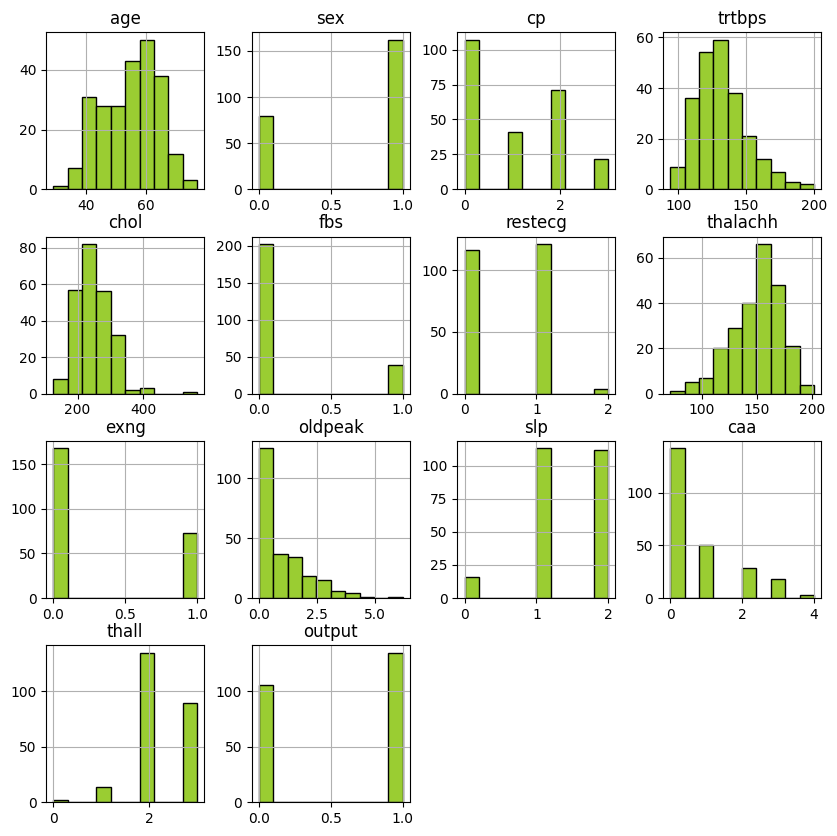

Number of people that suffered from heart attack:  135
Number of people that did not suffer from heart attack:  106 

Number of males: 162 (67.22%)
Number of females: 79 (32.78%)


In [5]:
df_train.hist(figsize=(10, 10), color = 'yellowgreen', edgecolor = 'black')
plt.show()
print("Number of people that suffered from heart attack: ", df_train[df_train['output'] == 1].shape[0])
print("Number of people that did not suffer from heart attack: ", df_train[df_train['output'] == 0].shape[0], "\n")
n_males = df_train[df_train['sex'] == 1].shape[0]
print("Number of males:", n_males, f"({100 * n_males / (df_train.shape[0]):.2f}%)")
print("Number of females:", df_train.shape[0] - n_males, f"({100 * (df_train.shape[0] - n_males) / (df_train.shape[0]):.2f}%)")

It can be noticed that the number of people that did not have an heart attack are of the same order of the people that did. This means that we do not need to resample our dataset.

It can also be noticed that the females make up only one third of the database, this means that predictions on females might be less accurate.

We now plot the correlation matrix to see how the features are correlated with each other and with the target variable.

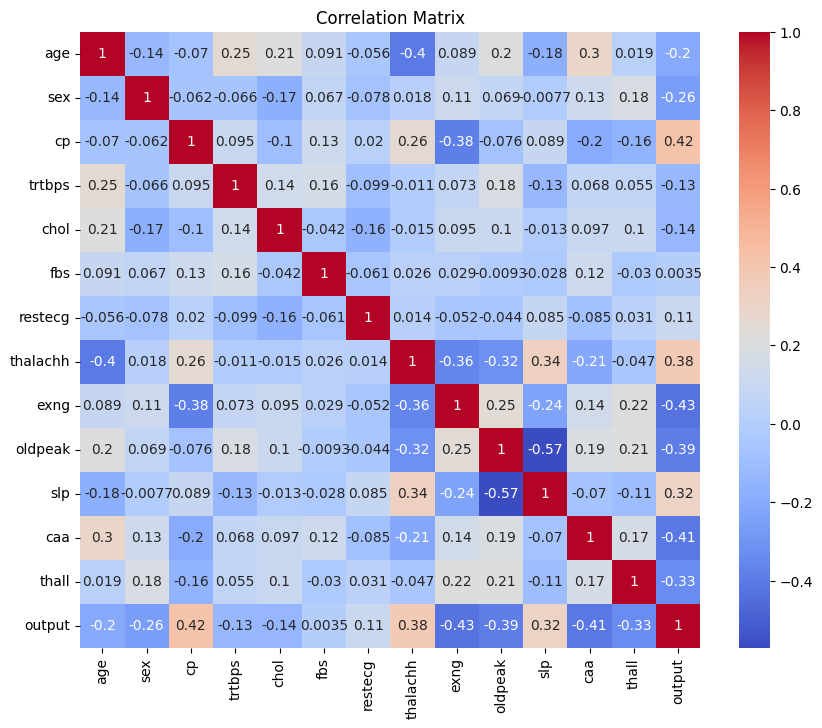

In [6]:
corr_matrix = df_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Let us plot the features that have the biggest correlation with the target feature and see if we can get some insights.

In [7]:
print(corr_matrix['output'].abs().sort_values(ascending=False))

output     1.00
exng       0.43
cp         0.42
caa        0.41
oldpeak    0.39
thalachh   0.38
thall      0.33
slp        0.32
sex        0.26
age        0.20
chol       0.14
trtbps     0.13
restecg    0.11
fbs        0.00
Name: output, dtype: float64


<Figure size 1500x1000 with 0 Axes>

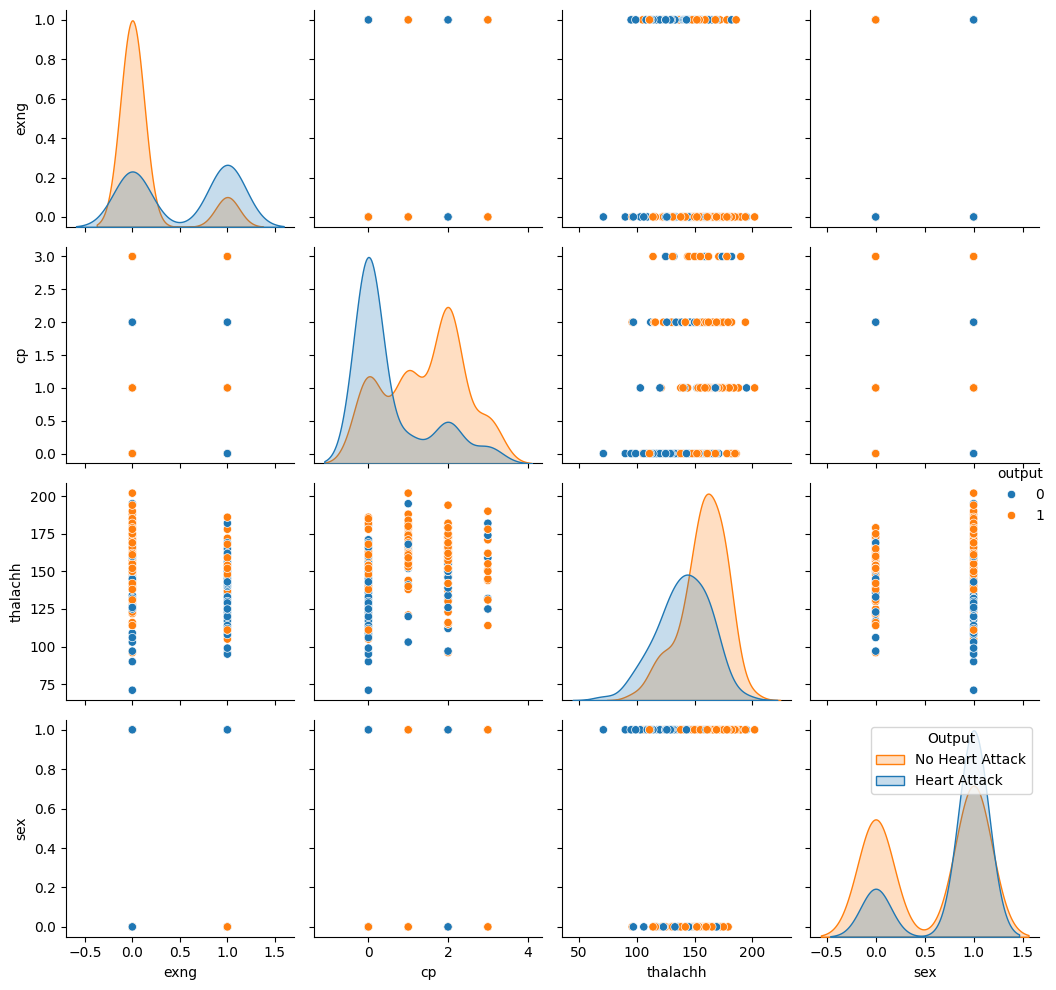

In [8]:
plt.figure(figsize=(15,10))
sns.pairplot(df_train[["exng", "cp", "thalachh", "sex", "output"]], hue="output")
plt.legend(title="Output", labels=["No Heart Attack", "Heart Attack"])
plt.tight_layout()
plt.show()

Based on these plots we can make some initial observations.

The graph on the top left shows the relation between _exercise induced angina_ and having a heart attack, while the second distribution graph shows the relation between  the _chest pain type_ and the target variable. In both cases having angina is correlated with a higher risk of heart failure.

The third distribution graph shows that having a higher _maximum achieved heart rate_ means being less likely to suffer from heart attack.

Looking at the remaining graphs and at the correlation matrix we can also notice how the correlations between different variables is generally not too high.

### Data normalization
Since the ranges of values of the different data entries are on different scales it is important to normalize the data by rescaling the attributes. In particular I decided to use the _MinMaxScaler_ to ensure that all the entries are between $0$ and $1$.

In [9]:
scaler = MinMaxScaler()
df_train[:] = scaler.fit_transform(df_train[:])
df_train.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00,241.00
mean,0.53,0.67,0.34,0.35,0.28,0.16,0.27,0.60,0.30,0.16,0.70,0.18,0.77,0.56
std,0.19,0.47,0.35,0.17,0.12,0.37,0.27,0.17,0.46,0.18,0.31,0.25,0.20,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.38,0.00,0.00,0.25,0.20,0.00,0.00,0.50,0.00,0.00,0.50,0.00,0.67,0.00
50%,0.56,1.00,0.33,0.34,0.27,0.00,0.50,0.63,0.00,0.10,0.50,0.00,0.67,1.00
75%,0.69,1.00,0.67,0.43,0.35,0.00,0.50,0.73,1.00,0.26,1.00,0.25,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# Training
Since we previously noticed that the correlation between variables is not too high I decided to use all the features to train my models.

I start by decomposing the training dataset into the features $X_{train}$ and the target attribute $y_{train}$. 

In [10]:
X_train = df_train[df_train.columns[:-1]]
y_train = df_train["output"]
df_test[:] = scaler.transform(df_test[:]) 
X_test = df_test[df_test.columns[:-1]]
y_test = df_test["output"]
print(X_train.head())
print('\n------------------------------------\n')
print(y_train.head())

     age  sex   cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
215 0.29    0 0.00    0.36  0.49    1     0.00      0.50     1     0.48 0.50   
156 0.38    1 0.67    0.34  0.29    0     0.50      0.82     0     0.00 1.00   
217 0.71    1 0.00    0.34  0.47    1     0.00      0.47     1     0.29 1.00   
147 0.65    0 1.00    0.53  0.26    0     0.50      0.76     0     0.15 1.00   
302 0.58    0 0.33    0.34  0.25    0     0.00      0.79     0     0.00 0.50   

     caa  thall  
215 0.00   1.00  
156 0.00   0.67  
217 0.75   1.00  
147 0.00   0.67  
302 0.25   0.67  

------------------------------------

215    0
156    1
217    0
147    1
302    0
Name: output, dtype: int64


## PCA
Before using different algorithms to fit our data, I will perform Principal Component Analysis.

The main reason to perform it is to be able to visualize some results in 2 dimensions and get some insights on the predictions.

Cumulative Explained Variance ratio:
 [(0, 0.256), (1, 0.448), (2, 0.579), (3, 0.671), (4, 0.753), (5, 0.816), (6, 0.872), (7, 0.907), (8, 0.937), (9, 0.96), (10, 0.976), (11, 0.99), (12, 1.0)]


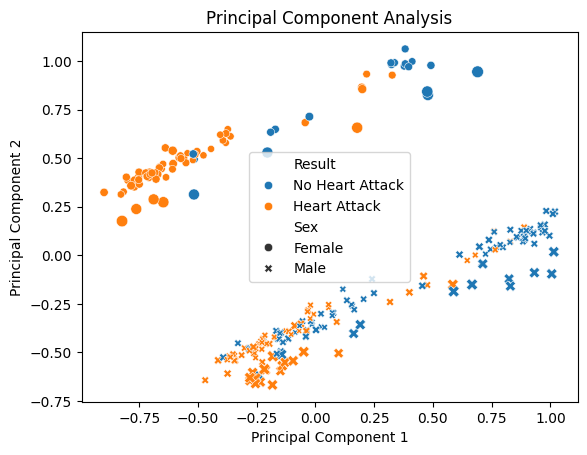

In [33]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA()
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Cumulative Explained Variance ratio:\n", list(enumerate(np.round(np.cumsum(pca.explained_variance_ratio_), 3))))

Pc1 = X_train_pca[:, 0]
Pc2 = X_train_pca[:, 1]
Pc3 = X_train_pca[:, 2]

Pc1_test = X_test_pca[:, 0]
Pc2_test = X_test_pca[:, 1]
Pc3_test = X_test_pca[:, 2]

gender_labels = np.where(X_train["sex"] == 1, 'Male', 'Female')
output_labels = np.where(y_train == 1, 'Heart Attack', 'No Heart Attack')

plot_data = pd.DataFrame({
    'Pc1': Pc1,
    'Pc2': Pc2,
    'Pc3': Pc3,
    'Result': output_labels,
    'Sex': gender_labels
})

scatter = sns.scatterplot(x='Pc1', y='Pc2', hue='Result', style='Sex', size='Pc3', data=plot_data)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Principal Component Analysis")

handles, labels = scatter.get_legend_handles_labels()

new_handles = handles[:3] + handles[-3:]
new_labels = labels[:3] + labels[-3:]

plt.legend(handles=new_handles, labels=new_labels)
plt.show()

# plot the explained variance
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Explained Variance')
# plt.title('Explained Variance Ratio')
# plt.grid(True)
# plt.show()

In the plot males are represented by a cross while females are represented by a circle, we can clearly distinguish males and females.

The color orange represents the participants that suffer from heart failure and blue the others.

The size of the marker represents the third principal component.

We can guess that having a smaller first principal component is correlated with a higher risk of heart attack.
This principal component analysis will be useful later when we will need to visualize some of the results.

## Binomial Logistic Regression

The first algorithm I am going to use will be logistic regression.

To avoid over-fitting we can introduce a L1 penalty term. Since the dataset I am using is small and the problem is not a multiclass problem I decided to use the solver `liblinear`.

To find the best value for $C$, I can use cross-validation. I will let $C$ vary on a logarithmic scale.

Best value of C: 0.5298316906283709
Test score: 0.820


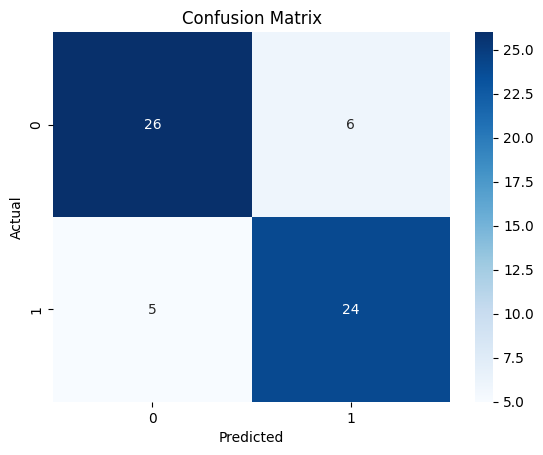

The indexes of the misclassified values are:  [ 2  5  7 24 36 40 42 43 53 56 58]


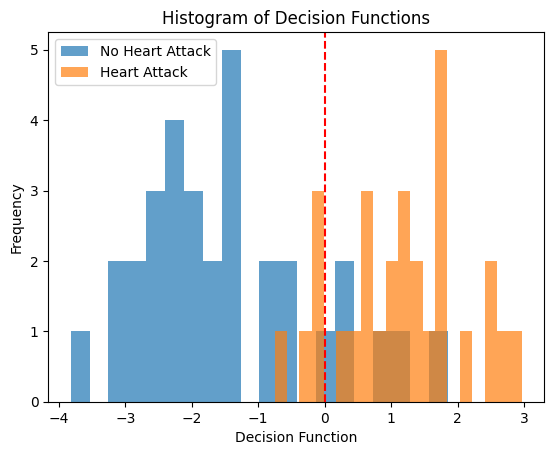

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the range of C values
C_values = np.logspace(-1, 2, 30)

# Create the logistic regression model
model = LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear')

# Create the parameter grid for GridSearchCV
param_grid = {'C': C_values}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=20)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best value of C
best_C = grid_search.best_params_['C']

# Print the best value of C
print("Best value of C:", best_C)
print("Test score: %.3f" % grid_search.score(X_test, y_test))

model = LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear', C=best_C)
# fit the model
model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = model.predict(X_test)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Calculate the decision functions for class 0 and 1
decision_func_0 = model.decision_function(X_test[y_test == 0])
decision_func_1 = model.decision_function(X_test[y_test == 1])


plt.hist(decision_func_0, bins=20, alpha=0.7, label='No Heart Attack')
plt.hist(decision_func_1, bins=20, alpha=0.7, label='Heart Attack')
plt.xlabel('Decision Function')
plt.ylabel('Frequency')
plt.title('Histogram of Decision Functions')
# lets add a vertical line
plt.axvline(x=0, color='red', linestyle='--')
plt.legend()
mis_KNN = np.where(y_test != y_pred)[0]
print("The indexes of the misclassified values are: ", mis_KNN)

The results obtained from Logistic regression are already accurate. Since the number of features is quite low ($13$) and the problem is a binary classification problem, a simple model such as Logistic Regression might be a good choice.

## K-Nearest Neighbors 

We can now try to use K-Nearest Neighbors. Our model contains $13$ features, this number is quite high and for this reason I will first apply a dimensionality reduction algorithm to avoid the effects of _"the curse of dimensionality"_. 

I will use PCA and I will keep $8$ variables. I found that this is a good balance between having enough cumulative explained variance ($90\%$) but not too many variables.

The optimal number of neighbors is 11.


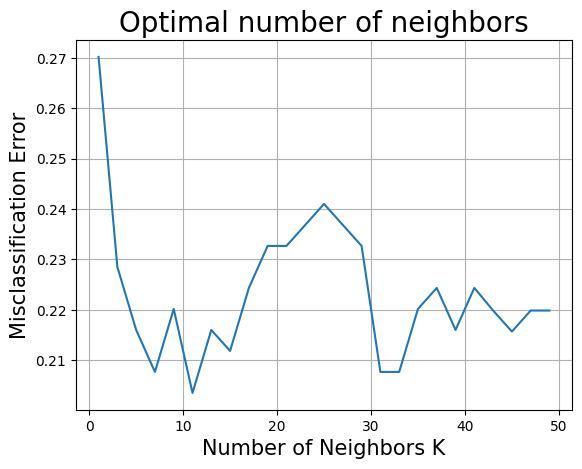

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

X_train_KNN = X_train_pca[:, :8]
X_test_KNN = X_test_pca[:, :8]

cv_scores = []
k_list = list(range(1, 50, 2))
for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train_KNN, y_train, cv=20, scoring='accuracy')
        cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]
plt.title('Optimal number of neighbors', fontsize=20)
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Misclassification Error', fontsize=15)
plt.plot(k_list, MSE)
plt.grid()

best_k = k_list[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d." % best_k)

In [14]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_KNN, y_train)
y_pred = knn.predict(X_test_KNN)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f" % accuracy)
mis_KNN = np.where(y_test != y_pred)[0]

Accuracy: 0.770


## Support Vector Machine

One of the models from which I obtained the best results was Support Vector Machine. To find the hyper-parameter $C$, I decided to use cross-validation, letting $C$ change on a logarithmic scale.

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best C value: 4.74
Training Accuracy: 0.93
Testing Accuracy: 0.87


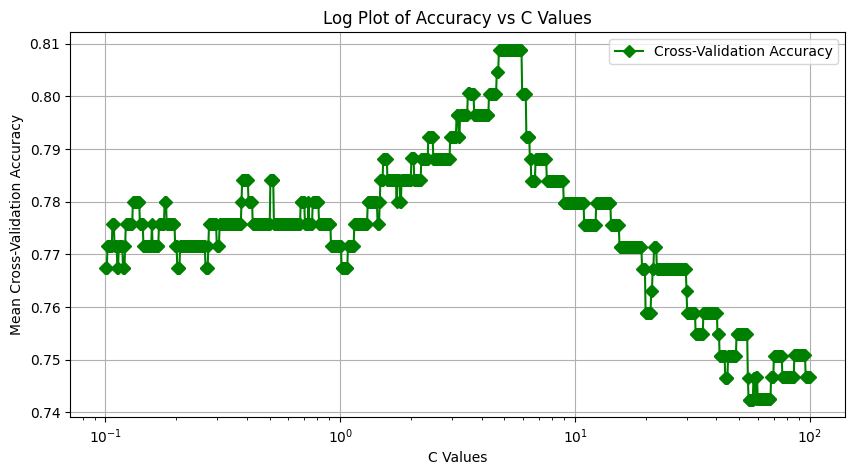

In [34]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define a range of C values to explore
C_values = np.logspace(-1, 2, 1000)

# Set up the parameter grid
param_grid = {'C': C_values}

# Initialize the classifier
clf_svm = svm.SVC(kernel="rbf")

# Set up GridSearchCV
grid_search = GridSearchCV(clf_svm, param_grid, cv=5, scoring='accuracy', verbose=1)  # 5-fold cross-validation

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Extract the best estimator
best_clf = grid_search.best_estimator_

# Predict using the best estimator
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

# Calculate and print the accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Best C value: {grid_search.best_params_['C']:.2f}")
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Plotting the results
results = grid_search.cv_results_
plt.figure(figsize=(10, 5))
plt.semilogx(results['param_C'].data.astype(float), results['mean_test_score'], '-gD', label='Cross-Validation Accuracy')
plt.xlabel('C Values')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Log Plot of Accuracy vs C Values')
plt.grid(True)
plt.legend()
plt.show()

In [36]:
print("Accuracy: %.3f" % test_accuracy)

mis_SVM = np.where(y_test != y_test_pred)[0]
print("The indexes of the misclassified values from SVM are: ", mis_SVM)
print("The indexes of the misclassified values from KNN are: ", mis_KNN)

Accuracy: 0.869
The indexes of the misclassified values from SVM are:  [10 19 28 31 40 42 48 56]
The indexes of the misclassified values from KNN are:  [ 2  7 10 14 15 19 24 35 40 43 46 49 56 58]


This model performs even better than KNN. It is also interesting to notice that typically the individuals that have been misclassified by SVM have also been misclassified by KNN. This might mean that those values are particularly difficult to be studied.

## Neural Network
The last algorithm I will use will be a neural network. I decided to build a neural network with one hidden layer and activation function ReLU. To be able to find the best learning rate and the best optimizer I will proceed with cross validation.

First of all I define the model.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(13, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.sigmoid(out)
        return out

I will not try to understand what learning rate is the most appropriate. I will make the learning rate vary on a logarithmic scale from $0.1$ to $0.0001$.

In [24]:
# Set the hyperparameters
hidden_size = 20  # Number of neurons in the hidden layer
output_size = 1   
num_epochs = 300  
k_folds = 4       # Number of folds for cross-validation
learning_rates = [0.1, 0.01, 0.001, 0.0001]  # Different learning rates to evaluate

# Creating dataset for K-fold cross-validation
X_train_torch = torch.FloatTensor(X_train.values)
y_train_torch = torch.FloatTensor(y_train.values.reshape(-1, 1))
X_test_torch = torch.FloatTensor(X_test.values)
y_test_torch = torch.FloatTensor(y_test.values.reshape(-1, 1))
dataset = TensorDataset(X_train_torch, y_train_torch)

results = {}

for lr in learning_rates:
    fold_accuracies = []  # Store accuracies for each fold
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X_train_torch)):
        # Create data loaders for the current split
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        
        train_loader = DataLoader(dataset, batch_size=10, sampler=train_subsampler)
        test_loader = DataLoader(dataset, batch_size=10, sampler=test_subsampler)
        
        model = NeuralNetwork(hidden_size, output_size)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCELoss()

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Evaluation loop
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                predicted = outputs.round()
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        # Calculate accuracy
        accuracy = 100 * correct / total
        fold_accuracies.append(accuracy)
        print(f'Fold {fold+1}, Learning Rate {lr}, Accuracy: {accuracy:.2f}%')

    # Average accuracy across folds
    avg_accuracy = np.mean(fold_accuracies)
    results[lr] = avg_accuracy
    print(f'Average Accuracy for learning rate {lr}: {avg_accuracy:.2f}%\n')

# Determine the best learning rate
best_lr = max(results, key=results.get)
print(f'Best learning rate: {best_lr} with average accuracy {results[best_lr]:.2f}%')

Fold 1, Learning Rate 0.1, Accuracy: 73.77%
Fold 2, Learning Rate 0.1, Accuracy: 80.00%
Fold 3, Learning Rate 0.1, Accuracy: 78.33%
Fold 4, Learning Rate 0.1, Accuracy: 76.67%
Average Accuracy for learning rate 0.1: 77.19%

Fold 1, Learning Rate 0.01, Accuracy: 78.69%
Fold 2, Learning Rate 0.01, Accuracy: 80.00%
Fold 3, Learning Rate 0.01, Accuracy: 76.67%
Fold 4, Learning Rate 0.01, Accuracy: 76.67%
Average Accuracy for learning rate 0.01: 78.01%

Fold 1, Learning Rate 0.001, Accuracy: 80.33%
Fold 2, Learning Rate 0.001, Accuracy: 75.00%
Fold 3, Learning Rate 0.001, Accuracy: 91.67%
Fold 4, Learning Rate 0.001, Accuracy: 73.33%
Average Accuracy for learning rate 0.001: 80.08%

Fold 1, Learning Rate 0.0001, Accuracy: 83.61%
Fold 2, Learning Rate 0.0001, Accuracy: 85.00%
Fold 3, Learning Rate 0.0001, Accuracy: 76.67%
Fold 4, Learning Rate 0.0001, Accuracy: 75.00%
Average Accuracy for learning rate 0.0001: 80.07%

Best learning rate: 0.001 with average accuracy 80.08%


Now that we found the best learning rate using cross validation we can try to understand which optimizer is the best. I will try to use _Adam_, _Stochastic Gradient Descent_, and _RMSprop_.

In [25]:
model = NeuralNetwork(hidden_size, output_size)

# Set the hyperparameters
hidden_size = 20  # Number of neurons in the hidden layer
output_size = 1   # Number of output classes (binary classification)
num_epochs = 100  
k_folds = 5       # Number of folds for cross-validation
learning_rate = best_lr  # Best learning rate

# List of optimizers to evaluate
optimizers = {
    'SGD': lambda params: optim.SGD(params, lr=learning_rate),
    'Adam': lambda params: optim.Adam(params, lr=learning_rate),
    'RMSprop': lambda params: optim.RMSprop(params, lr=learning_rate)
}

results = {}

for optimizer_name, optimizer_fn in optimizers.items():
    fold_accuracies = []  # Store accuracies for each fold
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X_train_torch)):
        # Create data loaders for the current split
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        
        train_loader = DataLoader(dataset, batch_size=10, sampler=train_subsampler)
        test_loader = DataLoader(dataset, batch_size=10, sampler=test_subsampler)
        
        model = NeuralNetwork(hidden_size, output_size)
        optimizer = optimizer_fn(model.parameters())
        criterion = nn.BCELoss()

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Evaluation loop
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                predicted = outputs.round()
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        # Calculate accuracy
        accuracy = 100 * correct / total
        fold_accuracies.append(accuracy)
        print(f'Fold {fold+1}, Optimizer {optimizer_name}, Accuracy: {accuracy:.2f}%')

    # Average accuracy across folds
    avg_accuracy = np.mean(fold_accuracies)
    results[optimizer_name] = avg_accuracy
    print(f'Average Accuracy for optimizer {optimizer_name}: {avg_accuracy:.2f}%\n')

# Determine the best optimizer
best_optimizer = max(results, key=results.get)
print(f'Best optimizer: {best_optimizer} with average accuracy {results[best_optimizer]:.2f}%')

Fold 1, Optimizer SGD, Accuracy: 71.43%
Fold 2, Optimizer SGD, Accuracy: 50.00%
Fold 3, Optimizer SGD, Accuracy: 62.50%
Fold 4, Optimizer SGD, Accuracy: 60.42%
Fold 5, Optimizer SGD, Accuracy: 52.08%
Average Accuracy for optimizer SGD: 59.29%

Fold 1, Optimizer Adam, Accuracy: 89.80%
Fold 2, Optimizer Adam, Accuracy: 89.58%
Fold 3, Optimizer Adam, Accuracy: 87.50%
Fold 4, Optimizer Adam, Accuracy: 72.92%
Fold 5, Optimizer Adam, Accuracy: 75.00%
Average Accuracy for optimizer Adam: 82.96%

Fold 1, Optimizer RMSprop, Accuracy: 79.59%
Fold 2, Optimizer RMSprop, Accuracy: 83.33%
Fold 3, Optimizer RMSprop, Accuracy: 83.33%
Fold 4, Optimizer RMSprop, Accuracy: 81.25%
Fold 5, Optimizer RMSprop, Accuracy: 77.08%
Average Accuracy for optimizer RMSprop: 80.92%

Best optimizer: Adam with average accuracy 82.96%


The best optimizer is _Adam_. I can finally train my model using the results found by cross-validation. This time I can increase the number of epochs to obtain a higher accuracy.
I will also implement early stopping, this will allow me to have a smaller generalization error and a faster computation time.

Epoch 200/8000, Train Loss: 0.4369, Validation Loss: 0.3939
Epoch 400/8000, Train Loss: 0.3788, Validation Loss: 0.3225
Epoch 600/8000, Train Loss: 0.3699, Validation Loss: 0.3127
Epoch 800/8000, Train Loss: 0.3636, Validation Loss: 0.3074
Epoch 1000/8000, Train Loss: 0.3560, Validation Loss: 0.3011
Epoch 1200/8000, Train Loss: 0.3505, Validation Loss: 0.2969
Epoch 1400/8000, Train Loss: 0.3468, Validation Loss: 0.2941
Epoch 1600/8000, Train Loss: 0.3446, Validation Loss: 0.2924
Epoch 1800/8000, Train Loss: 0.3433, Validation Loss: 0.2914
Stopping early at epoch 1829


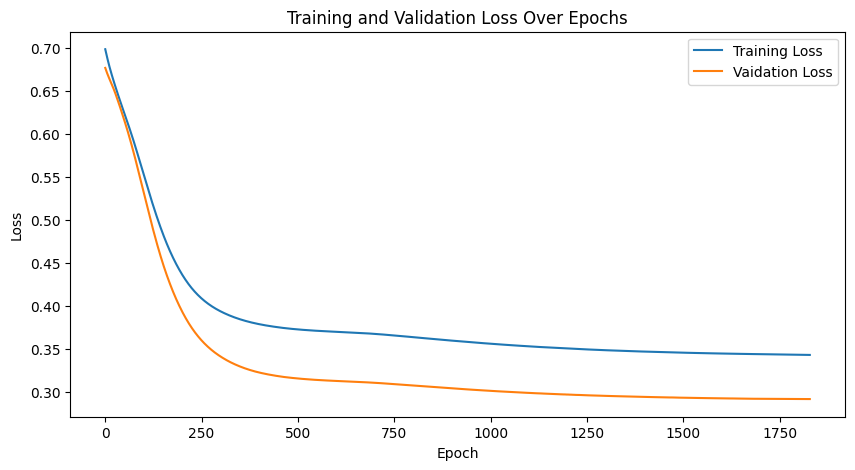

Accuracy: 0.92


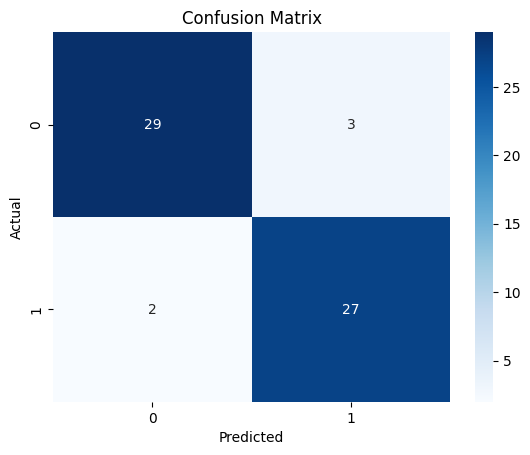

Accuracy: 0.918


In [26]:
# Set the hyperparameters
hidden_size = 20 # Number of neurons in the hidden layer
output_size = 1 # Number of output classes (binary classification)
patience = 20

learning_rate = best_lr
num_epochs = 4000
train_losses = []
val_losses = []
early_stop_counter = 0
best_val_loss = float("inf")

# Create an instance of the neural network
model = NeuralNetwork(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)

X_train_torch = torch.FloatTensor(X_train.values)
y_train_torch = torch.FloatTensor(y_train.values)
X_test_torch = torch.FloatTensor(X_test.values)
y_test_torch = torch.FloatTensor(y_test.values)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch.view(-1, 1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validate
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_test_torch).view(-1), y_test_torch).item()
        val_losses.append(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Stopping early at epoch {epoch + 1}")
                break

        # Print the loss every few epochs
        if (epoch + 1) % 200 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')


# plt the training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Vaidation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the model
with torch.no_grad():
    predicted = model(X_test_torch).view(-1)
    predicted = predicted.round() # Round the predictions to 0 or 1
    accuracy = (predicted == y_test_torch).sum() / y_test_torch.size(0)
    print(f'Accuracy: {accuracy:.2f}')

# plot the confusion matrix
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# print accuracy 
accuracy = accuracy_score(y_test, predicted)
print("Accuracy: %.3f" % accuracy)

To avoid over-fitting I also introduced a regularization term, a weight decay.

I can now try to understand where the model is failing. To do this I will use PCA.

The index of the misclassified values are: [ 2 36 40 42 56]


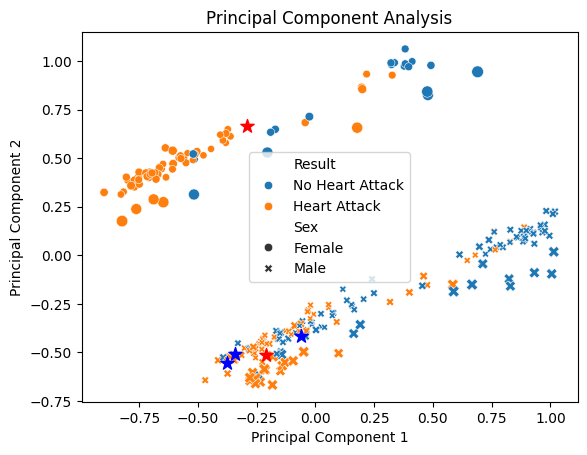

In [27]:
mis_indexes = np.where((predicted != y_test_torch).numpy())[0] 

print("The index of the misclassified values are:", mis_indexes)

scatter = sns.scatterplot(x='Pc1', y='Pc2', hue='Result', style='Sex', size='Pc3', data=plot_data)

for i in mis_indexes:
    if y_test_torch[i] == 0:
        plt.scatter(Pc1_test[i], Pc2_test[i], color='blue', s = 100, marker = "*", label='Misclassified Points') # it predicted 1 but it was 0
    else:
        plt.scatter(Pc1_test[i], Pc2_test[i], color='red', s = 100, marker = "*") # it predicted 0 but it was 1

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Principal Component Analysis")

plt.legend(handles=new_handles, labels=new_labels)
plt.show()

In [29]:
n_test_females = X_test[X_test["sex"] == 0].shape[0]
n_test_males = X_test[X_test["sex"] == 1].shape[0]

# number of misclassified females
mis_female = len([i for i in mis_indexes if X_test.iloc[i]["sex"] == 0])
print(f"{mis_female} females out of {n_test_females} have been misclassified ({100 * mis_female / n_test_females:.2f} %)")
mis_male = len([i for i in mis_indexes if X_test.iloc[i]["sex"] == 1])
print(f"{mis_male} males out of {n_test_males} have been misclassified ({100 * mis_male / n_test_males:.2f} %)")

1 females out of 17 have been misclassified (5.88 %)
4 males out of 44 have been misclassified (9.09 %)


The red stars represents points that should be orange, or type 1 error (individuals predicted with heart attack that did not have it).

The blue stars represents points that should be blue, or type 2 error (which is individuals predicted without heart attack that actually had one).

Just by looking at the plot of the 2 principal components we can notice that those values appear "out of place". We can see some blue stars in the bottom left part of the graph, these values might have been misclassified by the neural network because of the similar features shared with individuals that did have a heart attack. 

Similar observations could be made looking at the other misclassified values. It is important to remember that the first 2 principal components only explain $46\%$ of the dataset, this means that it is difficult to take accurate conclusions only by looking at the PCA graph. 

Looking at the PCA graph, we notice something else. Even thought the neural network has been trained on double as many males as females, it performs better on female.

# Conclusion


Every model performed quite well on the dataset. These are some accuracy results obtained from one test-train split.
* Binary Logistic Regression: $82.0\%$
* K-Nearest Neighbors: $77.0\%$
* Support Vector Machine: $86.9\%$
* Neural Network: $91.8\%$

It is important to note that changing the way the data is split had an impact on the performance of each method but some general conclusions can still be taken.
The best models are Support Vector Machine and Neural Network. Those two models would consistently have an accuracy greater than $85\%$.

Binary Logistic Regression had an accuracy greater than $80\%$. The dataset I decided to use was not too complex, this might explain why even a simple model such as logistic regression performed well.

K-Nearest Neighbors did not perform as good. This might be because the number of features is too high ($13$). After performing PCA and keeping the first $8$ components the performance would generally improve, but the results were never too promising. 